# Logistic Regression
### Task 1
We are going to be using Logistic Regression in order to attempt to solve the problem of sentiment analysis. While this may not be the absolute best approach to this topic, I believe that it will do a sufficient job. This is because many individual words are highly correlated to the sentiment of the overall statement. For example the word "Amazing" being somewhere in a movie review typically indicates that it is a good review. If we take a bag of words approach to the problem the linear model can assign high weights to positive words and low weights to negative words thus allowing a basic way of assigning sentiment. This method failes to capture temporal and interword relations. For example "I really wished that the movie would be great, however this was not true" is a more intricate example that probably will not be well classified by this approach to the problem. 

## Data Analysis / Visualization
### Task 2
Dataset: http://ai.stanford.edu/~amaas/data/sentiment/ \
We are attempting to see how correlated certain words are to the sentiment of a positive movie review. To do this we will collect a count of the total occurences of certain words in positive examples as well as their total counts in the dataset overall. The graph below demonstrates that the occurences of certain individual words can be used to reason about how positive a certain review is. While using a bag of words approach to sentiment analysis takes away the temporal relationship between words logistic regression may well be a good method for simple examples as well as a good possible baseline for future models on this topic. We also remove words that have less than 100 total occurences in the dataset. This should allow the parameters of the model to be based off of words which we have sufficent data to reason about. It also prevents over-fitting to certain phrases that appear with low frequency, for example if "iiiii" appears once and the one apperance is of positive sentiment then Gradient Descent may make the weight related to this word extremely high so that all future occurences of this word are also classified as positive.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import string
import os

In [2]:
TOP_N_WORDS = 2000
PROVIDED_VOCAB_PATH = "/home/lenny/Documents/PROGRAMMING/CSCI4967/hw1/aclImdb/imdb.vocab"
VOCAB_PATH = "/home/lenny/Documents/PROGRAMMING/CSCI4967/hw1/vocab.txt"
TRAIN_PATH = "/home/lenny/Documents/PROGRAMMING/CSCI4967/hw1/aclImdb/train"

In [3]:
##Construct a vocabulary using the top N words
f = open(PROVIDED_VOCAB_PATH, 'r')
vocab = f.readlines()[:TOP_N_WORDS]
vocab_list = [word.strip() for word in vocab]
word_index = { vocab_list[i] : i for i in range(len(vocab_list)) }
#print(word_index)
#print(vocab)

In [4]:
#Create the Updated Vocab (Remove Words with low occurence rate)
#Collect the total amount of % of times each word was seen in a postive/negative review
#score = total_pos_appearences/ total_apperances
POS_PATH = os.path.join(TRAIN_PATH, "pos")
NEG_PATH = os.path.join(TRAIN_PATH, "neg")
POSITIVE_EXAMPLES = os.listdir(POS_PATH)
NEGATIVE_EXAMPLES = os.listdir(NEG_PATH)
total_count = [0 for _ in range(len(vocab))]
positive_count = [0 for _ in range(len(vocab))]
for file in POSITIVE_EXAMPLES:
    f = open(os.path.join(POS_PATH, file), 'r')
    example = f.read().strip()
    example = example.translate(str.maketrans('','',string.punctuation))
    example = example.split()
    for word in example:
        if word in word_index:
            total_count[word_index[word]]+=1
            positive_count[word_index[word]]+=1
    f.close()
    
for file in NEGATIVE_EXAMPLES:
    f = open(os.path.join(NEG_PATH, file), 'r')
    example = f.read().strip()
    example = example.translate(str.maketrans('','',string.punctuation))
    example = example.split()
    for word in example:
        if word in word_index:
            total_count[word_index[word]]+=1
    f.close()
    
scores = [0.5 if total < 100 else pos/total for pos,total in zip(positive_count, total_count)]
#print(scores)



In [5]:
#Find Top 15 words 
zipped_index = sorted([(score, index) for index,score in zip(range(len(scores)), scores)], key=lambda x: (-x[0], -x[1]))
zipped_index = zipped_index[:7] + zipped_index[-7:]
#print(zipped_index)

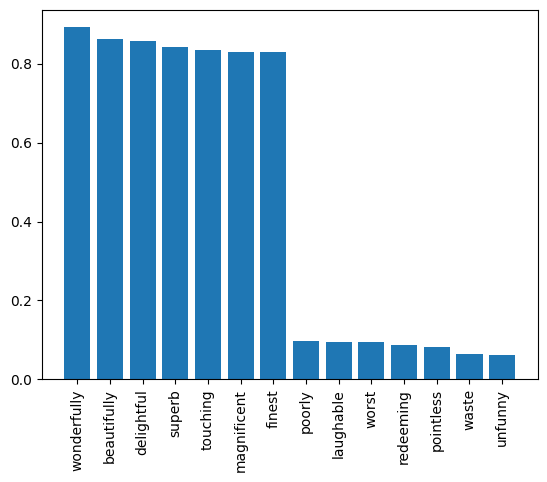

In [6]:
x = [vocab_list[item[1]] for item in zipped_index]
y = [item[0] for item in zipped_index]
plt.bar(x,y)
plt.xticks(rotation=90)
plt.show()

In [7]:
#Remove Words with less than 100 occurences
temp = []
for i, count in enumerate(total_count):
    if count >= 100:
        temp.append(vocab[i])

vocab = temp
word_index = { vocab_list[i] : i for i in range(len(vocab)) }

In [8]:
#Create Dataset using updated vocab 
DSET = []
for file in POSITIVE_EXAMPLES:
    f = open(os.path.join(POS_PATH, file), 'r')
    example = f.read().strip()
    example = example.translate(str.maketrans('','',string.punctuation))
    example = example.split()
    wc = [0 for _ in range(len(vocab))]
    for word in example:
        if word in word_index:
            wc[word_index[word]]+=1
    DSET.append((wc, 1))
    f.close()
    
for file in NEGATIVE_EXAMPLES:
    f = open(os.path.join(NEG_PATH, file), 'r')
    example = f.read().strip()
    example = example.translate(str.maketrans('','',string.punctuation))
    example = example.split()
    wc = [0 for _ in range(len(vocab))]
    for word in example:
        if word in word_index:
            wc[word_index[word]]+=1
    DSET.append((wc, 0))
    f.close()
    
random.shuffle(DSET)
#print(len(DSET))

## Implementing Logistic Regression
### Task 3
Now we are going to try and implement logistic regression

In [9]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
    
def loss(X, Y_hat, Y):
    n = X.shape[1]
    eps = 1e-4
    loss = (-1/n) * np.sum( Y*np.log(Y_hat+ eps) + (1-Y)*np.log(1-Y_hat+ eps) )
    dW = (1/n) * X@(Y_hat-Y).T
    dB = (1/n) * np.sum(Y_hat - Y)
    return loss, dW, dB

class LogisticRegression:
    def __init__(self, num_features):
        self.W = np.random.normal(size=(num_features, 1))
        self.b = 0
    def __call__(self, X):
        return sigmoid(self.W.T@X + self.b)
#x = np.random.normal(size=(10,3))
#print(lm(x))
#loss(x, lm(x), np.array([[1, 1, 1]]))

In [28]:
#Hyper Parameters
EPOCHS = 1000
batch_size = 2048
lr = .1
lr_decay = .99
lm = LogisticRegression(len(vocab))

In [29]:
##Train With MiniBatch Gradient Descent
for _ in range(EPOCHS):
    running_loss = 0
    for i in range(len(DSET)//batch_size):
        batch = DSET[i*256: (i+1)*256]
        X = np.array([x[0] for x in batch]).T
        Y = np.array([x[1] for x in batch])
        Y_hat = lm(X)
        l, dW, dB = loss(X,Y_hat,Y)
        lm.W -= lr*dW
        lm.b -= lr*dB
        running_loss += l
    lr *= lr_decay
    print("Running Loss: ", running_loss/len(DSET))


Running Loss:  0.0016293133098917673
Running Loss:  0.0015313883288025224
Running Loss:  0.0014485483303216583
Running Loss:  0.0013858329011725778
Running Loss:  0.001329655064405285
Running Loss:  0.0012792257361414904
Running Loss:  0.0012390847130416814
Running Loss:  0.0012024896777544716
Running Loss:  0.0011676630568028545
Running Loss:  0.0011350991290849034
Running Loss:  0.0011060736838440566
Running Loss:  0.0010792205893091643
Running Loss:  0.0010548845397803119
Running Loss:  0.0010332970969069097
Running Loss:  0.001013594852362617
Running Loss:  0.0009955495851688215
Running Loss:  0.000978570498739279
Running Loss:  0.0009623873808229389
Running Loss:  0.0009470821517287885
Running Loss:  0.0009326122395720962
Running Loss:  0.0009187905546099689
Running Loss:  0.0009054748766926828
Running Loss:  0.0008926224614055553
Running Loss:  0.000880248585229479
Running Loss:  0.0008683701258937168
Running Loss:  0.0008569903906348884
Running Loss:  0.0008461060969131387
Runni

KeyboardInterrupt: 

In [33]:
def encode(str):
    str = str.translate(str.maketrans('','',string.punctuation))
    str = str.split()
    wc = [0 for _ in range(len(vocab))]
    for word in str:
        if word in word_index:
            wc[word_index[word]]+=1
    return wc

test = " is a delicious cinematic"
x = np.array(encode(test)).reshape(-1, 1)
lm(x)

array([[0.6223929]])

True